In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sopt.optimizers.tensorflow2 import LMA, NonLinearConjugateGradient, ScipyOptimizerInterface 
import dataclasses as dt
import time
tf.get_logger().setLevel('ERROR')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
@dt.dataclass
class OptimizerResult:
    x: np.ndarray
    loss_per_iter: np.ndarray
    runtime: float
    scipy_out: 'typing.Any' = None

In [4]:
def fun_rosenbrock(x):
    # outputs the residuals
    y1 = 10 * (x[1:] - x[:-1]**2)
    y2 = 1 - x[:-1]
    return tf.concat((y1, y2), axis=0)

def fun_loss(x):
    return 0.5 * tf.reduce_sum(x**2)

def ggn_preds_fn(v):
    return v
def ggn_loss_fn(v):
    return fun_loss(fun_rosenbrock(v))

In [43]:
z_init = np.random.random(20).astype('float32')

In [44]:
test_scipy_methods = ['CG', 'BFGS', 'L-BFGS-B', 'Newton-CG', 'trust-ncg']
test_scipy_ggn_methods = ['Newton-CG', 'trust-ncg']

In [45]:
results_all = {}

In [46]:
v1 = tf.Variable(z_init)
v2 = tf.Variable(z_init)

lm = LMA(input_var=v1, predictions_fn=fun_rosenbrock, loss_fn=fun_loss, name='lma', warm_start=True)
cg = NonLinearConjugateGradient(input_var=v2, objective_fn=ggn_loss_fn, name='cg')

lm_losses = []
cg_losses = []
start_time = time.time()
for i in range(100):
    lm_losses.append(lm.minimize().numpy())
lm_runtime = time.time() - start_time

start_time = time.time()
for i in range(100):
    cg_losses.append(cg.minimize().numpy())
cg_runtime = time.time() - start_time

results_all['tf-lm'] = OptimizerResult(loss_per_iter=np.array(lm_losses),
                             x=v1.numpy(),
                             runtime=lm_runtime)
results_all['tf-cg'] = OptimizerResult(loss_per_iter=np.array(cg_losses),
                             x=v2.numpy(),
                             runtime=cg_runtime)

del v1, v2, lm, cg

In [47]:
for method in test_scipy_methods:
    v = tf.Variable(z_init)
    opt = ScipyOptimizerInterface(input_var=v, predictions_fn=fun_rosenbrock, loss_fn=fun_loss, use_full_hessian=True, method=method)
    t1 = time.time()
    out = opt.minimize()
    results_all['sp-'+ method] = OptimizerResult(x=out.x,
                                            loss_per_iter=np.array(opt._loss_per_iter),
                                            runtime=time.time()-t1)
    
    
for method in test_scipy_ggn_methods:
    key = method + '-g'
    v = tf.Variable(z_init)
    opt = ScipyOptimizerInterface(input_var=v, predictions_fn=fun_rosenbrock, loss_fn=fun_loss, use_full_hessian=False, method=method)
    t1 = time.time()
    out = opt.minimize()
    results_all['sp-' + key] = OptimizerResult(x=out.x, loss_per_iter=np.array(opt._loss_per_iter),
                                         runtime=time.time()-t1)

/raid/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method CG does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '
/raid/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '
/raid/home/skandel/miniconda3/envs/tf2/lib/python3.8/site-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method L-BFGS-B does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


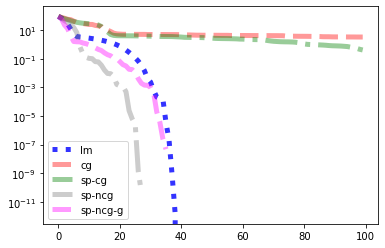

In [48]:
plt.plot(results_all['tf-lm'].loss_per_iter, color='blue', ls=':', linewidth=5.0, alpha=0.8, label='lm')
plt.plot(results_all['tf-cg'].loss_per_iter, color='red', ls='--', linewidth=5.0, alpha=0.4, label='cg')
plt.plot(results_all['sp-CG'].loss_per_iter, color='green', ls='-.', linewidth=5.0, alpha=0.4, label='sp-cg')
plt.plot(results_all['sp-Newton-CG'].loss_per_iter, color='grey', ls='-.', linewidth=5.0, alpha=0.4, label='sp-ncg')
plt.plot(results_all['sp-Newton-CG-g'].loss_per_iter, color='magenta', ls='--', linewidth=5.0, alpha=0.4, label='sp-ncg-g')


plt.yscale('log')
plt.legend(loc='best')
plt.show()

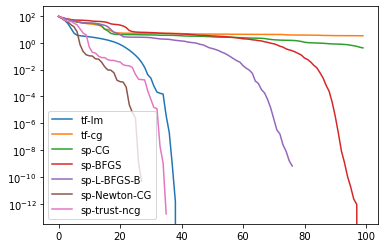

In [49]:
for k in results_all:
    if k[-2:] == '-g':
        continue
    plt.plot(results_all[k].loss_per_iter, label=k)
plt.yscale('log')
plt.legend(loc='best')
plt.show()

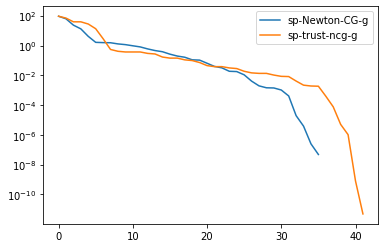

In [50]:
for k in results_all:
    if k[-2:] != '-g':
        continue
    plt.plot(results_all[k].loss_per_iter, label=k)
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [ ]:
#This is not exactly accurate
print('Method\t Iterations\t Runtime per iteration\t total runtime')
for key in results_all:
    n = results_all[key].loss_per_iter.size
    rpi = results_all[key].runtime / n
    print(f'{key:15s} {n:8d} {rpi:8.2g} {results_all[key].runtime:8.2g}')